### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM (i.e. the model can be applied to normal dynamic pipelay condition as a rough estimate)

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 59.1       #  (submerged pipe weight) [kg/m]
N = 16       # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 168 # [m]
B = 46
H = 13.5
Xg = L/2 # [m]
mn = 39_989_000  # mass of the vessel, [kg]

In [8]:
Fx_0 = 604.76664*1000
Fy_0 = 0.7*Fx_0
LTD = 255.21207

In [9]:
lx, ly, lz = L/2, B/2, H/2

In [10]:
vessel_mass = mn/L # mass over length of the vessel

In [11]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.508 # Outer diameter of pipe, [m]
dI= (508-22.1*2)/1000 # Inner diameter of pipe, [m]

In [13]:
rho_steel=7850 #kg/m^3
rho_steel *= 9.81

In [14]:
Ar=np.pi*((d0/2)**2-(dI/2)**2) 
Iy_ = 1/4*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
Iz_ = 1/2*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
J_ = 1/32*np.pi*(d0**4-dI**4)

In [15]:
E = 207e9
G = 79.3e9

In [16]:
h = 40 # water depth

In [17]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [18]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [19]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [20]:
# Constants: 

In [21]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [22]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [23]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [24]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [25]:
# for testing:

In [26]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [27]:
φ

array([0.31806618, 0.38461213, 0.5800891 , 0.571235  , 0.49598973,
       0.06904524, 0.85135369, 0.43050496, 0.30972895, 0.34822409,
       0.12656904, 0.42697358, 0.9338766 , 0.80309835, 0.29832498,
       0.29266831])

In [28]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [29]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [30]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [31]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

In [32]:
# integration parameters
tspan = (0., 100)

coefs = [1, 1, 1, 1, 1, 1]
k500 = 6
lift_reduction_factor=1e-03
vessel_motion_calibration_coefficient = 1000

In [33]:
Tp=10
z_acceleration_factor=1e-06

### Main functions:

In [34]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [35]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [36]:
Π(φ,θ,ψ)

array([[[ 0.72168922,  0.        ,  0.65749695],
        [ 0.        ,  1.        , -0.31273032],
        [-0.69221721,  0.        ,  0.6854907 ]],

       [[ 0.84982399,  0.        ,  0.48856122],
        [ 0.        ,  1.        , -0.37519963],
        [-0.52706658,  0.        ,  0.78773928]],

       [[ 0.56742845,  0.        ,  0.68872213],
        [ 0.        ,  1.        , -0.54809846],
        [-0.82342271,  0.        ,  0.474605  ]],

       [[ 0.87936597,  0.        ,  0.40055057],
        [ 0.        ,  1.        , -0.54067138],
        [-0.4761465 ,  0.        ,  0.73975246]],

       [[ 0.57521449,  0.        ,  0.71943177],
        [ 0.        ,  1.        , -0.47590235],
        [-0.81800262,  0.        ,  0.50590007]],

       [[ 0.94313496,  0.        ,  0.33161803],
        [ 0.        ,  1.        , -0.06899039],
        [-0.33241005,  0.        ,  0.94088778]],

       [[ 0.97398797,  0.        ,  0.14932142],
        [ 0.        ,  1.        , -0.75217313],
        

In [37]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [38]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.64742214, -0.06709826,  0.01980799],
       [ 0.67191365,  0.08264301, -0.32161873],
       [ 0.97244904,  0.1718974 , -0.4609571 ],
       [ 0.64841029,  0.53969559,  0.35926001],
       [ 0.82273587,  0.38827731,  0.14869155],
       [ 0.48168735,  0.24739646,  0.24049909],
       [ 0.34399743, -0.08152442,  0.11932947],
       [ 0.46804054,  0.49644057,  0.69269316],
       [ 0.74365481,  0.50212546,  0.63999046],
       [ 0.0388399 ,  0.90246664,  0.0503764 ],
       [ 0.81358902,  0.90049455, -0.17390246],
       [ 0.09783903,  0.15619667,  0.16369685],
       [ 0.46387248, -0.61088395,  0.16843308],
       [ 0.921119  ,  0.42875377, -0.25874365],
       [ 0.00399462,  0.39616162,  0.02022751],
       [ 0.57399728,  0.91936599, -0.18179389]])

In [39]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [40]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 0.89759817,  0.08146121,  0.61020898],
       [ 1.79626305,  0.011665  ,  0.20461965],
       [ 2.06527163,  0.51690214, -0.3778103 ],
       [ 1.06449006,  0.57690611,  0.50175134],
       [ 1.70557301,  1.03037359, -0.15778617],
       [ 1.1066841 ,  0.87322933,  0.32627983],
       [ 0.64357433,  0.13317819,  0.20271015],
       [ 1.0303533 ,  0.39295572,  0.93021403],
       [ 0.98420638,  0.3836571 ,  0.19836182],
       [ 0.79960091,  1.80593613, -0.22596784],
       [ 1.09072559,  1.1235529 , -0.51901682],
       [ 0.9426897 ,  0.62360109,  0.19756886],
       [ 0.57417595, -0.47899081,  1.04085065],
       [ 1.30558837, -0.03611788,  0.00228038],
       [ 0.03766322,  0.45606116,  0.6156155 ],
       [ 0.5928883 ,  1.65616475,  0.08786719]])

In [41]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [42]:
phi(x,y,z)

array([[0.20127493, 0.27864344, 0.07569035],
       [0.45570007, 0.64953193, 0.89136745],
       [0.13897078, 0.59728707, 0.14770858],
       [0.55273329, 0.72381896, 0.26471891],
       [0.61779147, 0.603062  , 0.42244278],
       [0.9081931 , 0.18752029, 0.19763904],
       [0.52640132, 0.32039269, 0.70319106],
       [0.68693959, 0.93662505, 0.4404143 ],
       [0.57938315, 0.16698168, 0.57194481],
       [0.49373742, 0.25097924, 0.4380054 ],
       [0.67687965, 0.12371338, 0.57019692],
       [0.10964085, 0.3477289 , 0.94899981],
       [0.54257233, 0.42003904, 0.00896764],
       [0.39736166, 0.47944726, 0.48025747],
       [0.5266611 , 0.95789714, 0.48800839],
       [0.63714179, 0.66220536, 0.40049697]])

In [43]:
theta(φ,θ,ψ)

array([[0.31806618, 0.7645568 , 0.48565846],
       [0.38461213, 0.55514506, 0.77798332],
       [0.5800891 , 0.96741685, 0.30962315],
       [0.571235  , 0.49626735, 0.72820611],
       [0.49598973, 0.95792999, 0.36002849],
       [0.06904524, 0.33885779, 0.29955528],
       [0.85135369, 0.22858518, 0.24846832],
       [0.43050496, 0.26166742, 0.11465523],
       [0.30972895, 0.09052024, 0.24578819],
       [0.34822409, 0.64410657, 0.31200889],
       [0.12656904, 0.91787352, 0.16515051],
       [0.42697358, 0.40845335, 0.74649973],
       [0.9338766 , 0.90461235, 0.52437861],
       [0.80309835, 0.51619173, 0.30656433],
       [0.29832498, 0.01042663, 0.88152278],
       [0.29266831, 0.36152359, 0.06152222]])

In [44]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [45]:
ω(x,y,z)

array([[ 0.21391013,  0.26351153,  0.01594086],
       [ 0.84700115,  0.25724909,  0.36180342],
       [ 0.19718061,  0.5768259 ,  0.04280013],
       [ 0.56335852,  0.58483744, -0.19723466],
       [ 0.70412347,  0.35836781, -0.06677644],
       [ 0.91493774,  0.03170296, -0.04985782],
       [ 0.69109477, -0.03290816,  0.41126943],
       [ 0.68133231,  0.65732581, -0.35160912],
       [ 0.65087165, -0.14616259,  0.37564938],
       [ 0.57405645,  0.04339961,  0.25098855],
       [ 0.72655516, -0.23343726,  0.35756344],
       [ 0.42452148,  0.24388809,  0.84948241],
       [ 0.49853993,  0.41540868, -0.21424672],
       [ 0.55683551,  0.2935939 ,  0.20960981],
       [ 0.64804696,  0.71259987, -0.18811827],
       [ 0.70040881,  0.42394953, -0.13787368]])

In [46]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [47]:
Ret(φ,θ,ψ)

array([[[ 7.39288306e-01, -1.45432317e-01,  6.57496952e-01],
        [ 4.43377470e-01,  8.40009622e-01, -3.12730322e-01],
        [-5.06822670e-01,  5.22717205e-01,  6.85490703e-01]],

       [[ 7.44148798e-01, -4.55577107e-01,  4.88561220e-01],
        [ 6.50570392e-01,  6.60290392e-01, -3.75199630e-01],
        [-1.51659918e-01,  5.97047818e-01,  7.87739279e-01]],

       [[ 6.77962436e-01,  2.56960619e-01,  6.88722132e-01],
        [ 2.54855066e-01,  7.96641057e-01, -5.48098460e-01],
        [-6.89504047e-01,  5.47114492e-01,  4.74604996e-01]],

       [[ 8.27665633e-01, -3.93101565e-01,  4.00550570e-01],
        [ 5.59867906e-01,  6.27871312e-01, -5.40671382e-01],
        [-3.89554456e-02,  6.71750531e-01,  7.39752457e-01]],

       [[ 6.75482639e-01,  1.61682192e-01,  7.19431771e-01],
        [ 3.09847980e-01,  8.23110675e-01, -4.75902348e-01],
        [-6.69116906e-01,  5.44378255e-01,  5.05900070e-01]],

       [[ 9.07902555e-01, -2.56402877e-01,  3.31618027e-01],
        [ 2.94

In [48]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [49]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[ 0.01495848, -0.01885127,  0.02962087],
       [-0.0317448 , -0.44325075,  0.33922219],
       [ 0.31535775, -0.12607664,  0.21311175],
       [-0.16589687, -0.06277456,  0.51803682],
       [ 0.46712402, -0.36806988, -0.15769302],
       [ 0.01433867,  0.20262498, -0.25814019],
       [ 0.04003387, -0.62678605,  0.25561159],
       [ 0.10421044, -0.20238229,  0.26786152],
       [-0.02532936, -0.06967342,  0.04600022],
       [ 0.22911035, -0.18655264, -0.15136689],
       [ 0.51160625, -0.11872596, -0.58156729],
       [-0.06361781, -0.57820773,  0.21921464],
       [ 0.23177212, -0.30116309,  0.0833123 ],
       [ 0.24324206, -0.4698391 ,  0.26778969],
       [-0.92544053,  0.2922306 ,  0.42512931],
       [ 0.16974329, -0.14882975, -0.02395696]])

In [50]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[ 0.21135282, -0.23070051,  0.22476589],
       [-0.02288165, -0.39224982,  0.29120947],
       [ 0.56692465, -0.35978181,  0.06198562],
       [-0.0576794 , -0.42585269,  0.33546172],
       [ 0.49737172, -0.30686402,  0.13127567],
       [ 0.00758678, -0.03138836,  0.03375791],
       [ 0.01800431, -0.24372278,  0.16252927],
       [ 0.02732079, -0.0553854 ,  0.02381765],
       [-0.01473369, -0.01748072,  0.0250045 ],
       [ 0.15137783, -0.13297754,  0.10556846],
       [ 0.14906878, -0.03431753,  0.07648577],
       [-0.11129757, -0.30013939,  0.22788228],
       [ 0.74312425, -0.9368699 ,  0.29276124],
       [ 0.19965702, -0.41597063,  0.17737345],
       [-0.22796085, -0.02028743,  0.07738648],
       [ 0.0386541 , -0.03229403,  0.0058877 ]])

In [51]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t1=np.einsum('ijk,kp->ijp',RET, np.array([0,0,1]).reshape(3,1)).squeeze()
    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [52]:
ne(x, y, z, φ, θ, ψ)

array([[ 1.49584823e+07, -1.88512653e+07,  2.96208681e+07],
       [-3.17447982e+07, -4.43250748e+08,  3.39222194e+08],
       [ 3.15357750e+08, -1.26076637e+08,  2.13111745e+08],
       [-1.65896867e+08, -6.27745638e+07,  5.18036818e+08],
       [ 4.67124020e+08, -3.68069876e+08, -1.57693022e+08],
       [ 1.43386731e+07,  2.02624976e+08, -2.58140186e+08],
       [ 4.00338745e+07, -6.26786048e+08,  2.55611585e+08],
       [ 1.04210443e+08, -2.02382288e+08,  2.67861517e+08],
       [-2.53293618e+07, -6.96734169e+07,  4.60002247e+07],
       [ 2.29110351e+08, -1.86552639e+08, -1.51366888e+08],
       [ 5.11606255e+08, -1.18725957e+08, -5.81567285e+08],
       [-6.36178095e+07, -5.78207729e+08,  2.19214637e+08],
       [ 2.31772118e+08, -3.01163087e+08,  8.33122952e+07],
       [ 2.43242062e+08, -4.69839095e+08,  2.67789686e+08],
       [-9.25440527e+08,  2.92230597e+08,  4.25129309e+08],
       [ 1.69743291e+08, -1.48829746e+08, -2.39569592e+07]])

In [53]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[ 2.02733720e+07, -1.45713536e+07, -1.95114919e+07],
       [ 2.71090124e+08, -2.52831019e+08, -3.04997252e+08],
       [ 1.28307199e+08, -2.19884440e+08, -3.19949330e+08],
       [ 6.98652180e+07, -4.55570186e+08, -3.28312551e+07],
       [-2.06333971e+08, -1.86058360e+07, -5.67782297e+08],
       [-1.34596887e+08,  4.61651714e+07,  2.87606362e+07],
       [-1.03044269e+07, -2.22777715e+08, -5.44660123e+08],
       [ 5.51039312e+07, -1.19727561e+08, -1.11897906e+08],
       [ 1.50102925e+07, -2.03586475e+07, -2.25706595e+07],
       [-7.66394699e+07,  7.46290311e+07, -2.07979031e+08],
       [-5.21800750e+08,  1.19882932e+08, -4.83503371e+08],
       [ 2.84274515e+08, -1.73943632e+08, -3.76300741e+08],
       [-1.22828224e+08, -1.94006846e+08, -3.59605304e+08],
       [-2.00784526e+07, -2.66558662e+08, -4.49441344e+08],
       [-3.51024048e+08, -9.07396976e+08, -1.40387216e+08],
       [-1.54418647e+07, -1.16132393e+06, -1.02196334e+08]])

In [54]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [55]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 5.48863890e+10,  6.12676670e+10,  1.12743476e+10],
       [ 7.06945097e+10,  2.63246003e+10,  4.10131824e+10],
       [ 5.42403374e+10,  7.97712874e+10, -3.30709839e+10],
       [ 7.94007991e+10,  1.02547146e+10,  2.66700716e+10],
       [ 5.44316416e+10,  7.86591581e+10, -2.23582458e+10],
       [ 1.64456913e+10,  3.18191355e+10,  2.58896573e+10],
       [ 8.66309889e+10,  4.16939823e+09, -3.34434563e+09],
       [ 4.42804545e+10,  2.13818386e+10, -1.07212251e+09],
       [ 3.29622067e+10,  1.56038763e+09,  2.05135779e+10],
       [ 4.54564048e+10,  5.37640081e+10,  2.54160754e+09],
       [ 2.07023657e+10,  8.97026347e+10, -1.00712951e+08],
       [ 6.61732602e+10,  9.93143842e+09,  4.53994880e+10],
       [ 8.22306204e+10,  4.83047875e+10, -5.41474231e+10],
       [ 8.03541656e+10,  2.95615235e+10, -2.11223724e+10],
       [ 3.07093933e+10, -2.48670177e+10,  8.39429787e+10],
       [ 2.94585025e+10,  3.43773936e+10, -4.84183220e+09]])

In [56]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[ 0.00000000e+00,  1.73382935e-06, -1.14440918e-05],
       [ 0.00000000e+00,  5.57568226e-07,  0.00000000e+00],
       [ 1.14440918e-05, -1.35575039e-05, -7.62939453e-06],
       [-9.53674316e-07, -7.11811357e-07,  9.53674316e-07],
       [-3.81469727e-06,  2.09493649e-06,  7.62939453e-06],
       [-9.53674316e-07,  9.99995702e-08,  0.00000000e+00],
       [-2.98023224e-08,  5.80302172e-10, -1.43051147e-06],
       [-2.68220901e-07,  5.69216223e-07,  1.90734863e-06],
       [ 1.78813934e-07, -1.25277154e-06, -2.98023224e-07],
       [ 1.90734863e-06, -1.22022508e-06, -7.62939453e-06],
       [-1.77323818e-06,  4.13101705e-07,  3.81469727e-06],
       [ 0.00000000e+00, -1.28143040e-06, -9.53674316e-07],
       [-7.62939453e-06,  8.19536689e-06,  0.00000000e+00],
       [-2.86102295e-06,  6.23683251e-06, -3.81469727e-06],
       [ 3.81469727e-06, -3.47974154e-06, -1.90734863e-06],
       [-9.53674316e-07,  1.05102628e-06,  1.90734863e-06]])

In [57]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [58]:
fD(dx,dy,dz).T

array([[2631.28923455,   80.55683897, 1339.22002973],
       [2183.40513747, 3120.53127607, 2161.31740657],
       [ 276.6899815 ,  720.53713159,  491.07758974],
       [  32.59766111, 4394.7397799 , 2698.14291696],
       [ 799.94542659, 1871.51917587,  655.91479798],
       [ 215.24134706, 1331.34447987, 3111.82984902],
       [  44.66434399, 3784.55849642, 4068.93236697],
       [ 930.07867055, 1161.56748797,  331.19653479],
       [  57.89985529, 4022.2491326 , 3233.67319138],
       [ 515.88054884, 1305.31197983, 1341.61632004],
       [  48.82135482,  775.72930006, 2112.94300099],
       [ 665.87979006,   18.64829099,  975.38527498],
       [3100.9740316 , 4592.55436774, 3680.81651112],
       [2668.02679874, 3382.71531449,   24.99239423],
       [2862.90196264,   60.95024271,   28.10892347],
       [2576.692368  ,  578.5506555 , 1851.00890272]])

In [59]:
fg_e = lift_reduction_factor*np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])          

In [60]:
fg_e

array([[0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063],
       [0.        , 0.        , 0.24055063]])

In [61]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [62]:
sigma(x,y,z)

array([[ 4.57046205,  4.57046205,  6.00411261],
       [ 4.57046205,  4.57046205, 21.4538483 ],
       [ 4.57046205,  4.57046205,  7.36820957],
       [ 4.57046205,  4.57046205,  9.58450153],
       [ 4.57046205,  4.57046205, 12.57194861],
       [ 4.57046205,  4.57046205,  8.31394203],
       [ 4.57046205,  4.57046205, 17.88960027],
       [ 4.57046205,  4.57046205, 12.91234706],
       [ 4.57046205,  4.57046205, 15.40366573],
       [ 4.57046205,  4.57046205, 12.86672002],
       [ 4.57046205,  4.57046205, 15.37055894],
       [ 4.57046205,  4.57046205, 22.5454626 ],
       [ 4.57046205,  4.57046205,  4.74031815],
       [ 4.57046205,  4.57046205, 13.66701635],
       [ 4.57046205,  4.57046205, 13.81382641],
       [ 4.57046205,  4.57046205, 12.15627305]])

In [63]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) #- sigma(x,y,z).T

In [64]:
ne_hat(x,y,z,dx,dy,dz).T

array([[-2631.28923455,   -80.55683897, -1339.46058037],
       [-2183.40513747, -3120.53127607, -2161.5579572 ],
       [ -276.6899815 ,  -720.53713159,  -491.31814037],
       [  -32.59766111, -4394.7397799 , -2698.3834676 ],
       [ -799.94542659, -1871.51917587,  -656.15534862],
       [ -215.24134706, -1331.34447987, -3112.07039966],
       [  -44.66434399, -3784.55849642, -4069.1729176 ],
       [ -930.07867055, -1161.56748797,  -331.43708542],
       [  -57.89985529, -4022.2491326 , -3233.91374201],
       [ -515.88054884, -1305.31197983, -1341.85687068],
       [  -48.82135482,  -775.72930006, -2113.18355163],
       [ -665.87979006,   -18.64829099,  -975.62582562],
       [-3100.9740316 , -4592.55436774, -3681.05706176],
       [-2668.02679874, -3382.71531449,   -25.23294486],
       [-2862.90196264,   -60.95024271,   -28.3494741 ],
       [-2576.692368  ,  -578.5506555 , -1851.24945336]])

In [65]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [66]:
RET = Ret(φ, θ, ψ)

In [67]:
Jrho(RET,Jrho0)

array([[[ -18.44029346,   45.76889809,  143.29769987],
        [ 101.72227538,   31.4195712 ,  -39.9924601 ],
        [ -83.77714988,  122.94314462,   44.3091128 ]],

       [[  10.91821481,   -5.6441522 ,  130.42123333],
        [ 102.74920453,  -30.84258158,  -52.10162186],
        [   3.66271392,  140.3953761 ,   94.29590687]],

       [[ -42.46326152,  113.2534745 ,   97.98299448],
        [ 113.16423832,   10.0379468 ,  -78.13739471],
        [ -98.25070745,   77.80050222,  -32.42495037]],

       [[  43.37381991,   -3.40337345,  113.66772439],
        [  85.70326112,  -55.22551416,  -91.51426076],
        [  28.62147066,  143.09445449,   71.56674812]],

       [[ -45.63942265,  102.55818771,  113.69399037],
        [ 110.12047255,   20.94663043,  -65.03238851],
        [ -96.031493  ,   89.07012604,  -22.85850892]],

       [[  55.08903781,  -37.08980572,   94.27968873],
        [  58.90658166,   81.09774235,   -9.79597164],
        [ -78.52768904,   53.08505272,  166.05262272]],

### Static solution

In [68]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [69]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [70]:
# Fx_0 = 82945396 
# Fy_0 = 82945396 

In [71]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [72]:
horizontal_length=2*(Fx_0/Ws[0])*(np.sinh(LTD*Ws[0]/(2*Fx_0)))

In [73]:
delta_x=horizontal_length/(N-1)

In [74]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [75]:
cum_len = 0
length_p1=[0]
for i in range(len(length_p)):
    cum_len+=length_p[i]
    length_p1.append(cum_len)

In [76]:
length_p1

[0,
 17.057176238530108,
 34.11891336134998,
 51.189773472166515,
 68.27432111384715,
 85.37712448881598,
 102.50275668042902,
 119.6557968756556,
 136.84083158939268,
 154.06245589074027,
 171.32527463156532,
 188.6339036776835,
 205.99297114298759,
 223.407118626853,
 240.8810024551517,
 258.41929492520603]

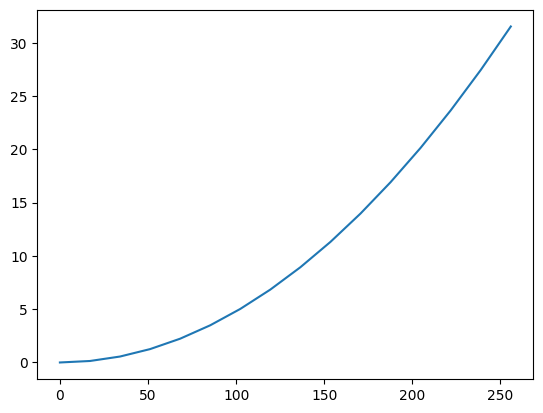

In [77]:
plt.plot(x0, z0)
plt.show()

In [78]:
q0=np.zeros(12*N)

In [79]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [80]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [81]:
root_ = root(static_func, q0, method='df-sane')

In [82]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.258e+01  1.258e+01 ...  0.000e+00  0.000e+00]
       x: [ 9.683e+01  1.139e+02 ...  0.000e+00  0.000e+00]
     nit: 323
    nfev: 1000
  method: df-sane

In [83]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [84]:
# q0 = root_.x                                            # start from static solution

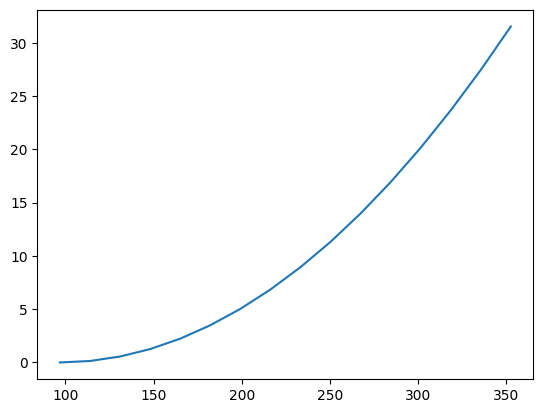

In [85]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [86]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [87]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [88]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [89]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [90]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [91]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [92]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [93]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=E, G=G, A=Ar, Iy=Iy_, Iz=Iz_, J=J_):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
    
    bc_node = list(range(3))+list(range((6*len(X)-6),6*len(X)))
    bc_val = [0]*3 + vessel_movement
    
    vessel_move=np.zeros(len(X)*6)

    d, f = FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [94]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [95]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.52592564e-03, -3.81469727e-03, -9.92584229e-03],
       [-8.01086426e-04, -7.70187378e-03,  2.44140625e-02],
       [ 2.14099884e-03, -2.05421448e-02, -3.49197388e-02],
       [-1.95860863e-03, -2.53295898e-02,  4.23793793e-02],
       [ 3.82995605e-03, -2.17895508e-02, -4.71343994e-02],
       [-4.67491150e-03, -1.80053711e-03,  4.91027832e-02],
       [ 5.53798676e-03,  2.60429382e-02, -4.80651855e-02],
       [-5.92505932e-03,  4.23889160e-02,  4.51526642e-02],
       [ 5.86509705e-03,  3.72924805e-02, -4.02221680e-02],
       [-5.55038452e-03,  8.08715820e-03,  3.46069336e-02],
       [ 5.25474548e-03, -3.01475525e-02, -2.89306641e-02],
       [-4.68438864e-03, -4.89196777e-02,  2.29477882e-02],
       [ 3.66687775e-03, -4.23889160e-02, -1.62239075e-02],
       [-2.71415710e-03, -1.77307129e-02,  1.12228394e-02],
       [ 1.51889746e+07, -2.32113720e+04, -3.44256264e+07]])

In [96]:
mom

array([[ 6.76965714e-03,  1.34234130e-03, -1.22070312e-03],
       [ 7.53402710e-04,  4.69970703e-03, -3.06701660e-03],
       [ 1.63364410e-02,  1.06811523e-03,  4.82177734e-03],
       [ 2.26058960e-02, -1.06201172e-02,  1.58691406e-03],
       [ 2.28118896e-02, -4.80651855e-03,  1.46484375e-03],
       [ 1.46236420e-02,  2.68554688e-03,  3.89099121e-03],
       [ 9.61303711e-04,  4.48608398e-03, -4.88281250e-03],
       [-1.50375366e-02,  1.70898438e-03, -2.01416016e-03],
       [-1.98059082e-02,  4.65154648e-03, -1.53808594e-02],
       [-1.78732872e-02,  4.39453125e-03, -1.95312500e-03],
       [-5.35583496e-03, -1.07192993e-03,  7.93457031e-03],
       [ 8.65173340e-03,  7.20214844e-03,  2.27050781e-02],
       [ 1.78985596e-02,  3.03649902e-03,  1.28173828e-02],
       [ 1.29423141e-02, -3.38745117e-03,  6.46972656e-03],
       [-2.99072266e-03, -2.74658203e-03, -4.69970703e-03],
       [-7.31955472e+05, -9.28673827e+09,  5.93862690e+06]])

In [97]:
angle

array([[-0.37732295,  0.02452897, -0.04168167],
       [-0.37732295,  0.02421295, -0.04168156],
       [-0.37662522,  0.02326236, -0.04166413],
       [-0.37453258,  0.02167189, -0.04157803],
       [-0.37034899,  0.01943571, -0.04133772],
       [-0.36338006,  0.01654744, -0.0408235 ],
       [-0.35293363,  0.01300019, -0.03988155],
       [-0.33832028,  0.00878649, -0.03832403],
       [-0.31885392,  0.00389832, -0.03592909],
       [-0.29385226, -0.0016729 , -0.03244106],
       [-0.26263733, -0.00793634, -0.02757047],
       [-0.22453602, -0.01490177, -0.02099422],
       [-0.1788805 , -0.02257956, -0.01235567],
       [-0.12500875, -0.03098068, -0.0012648 ],
       [-0.06226496, -0.04011675,  0.01270163],
       [ 0.01      , -0.05      ,  0.03      ]])

### Vessle Simulation

In [98]:
sampleTime = 0.01              # sample time [seconds]
Number = 60000                      # number of samples

In [99]:
Number*sampleTime

600.0

In [100]:
vehicle=semisub('DPcontrol',1,-1,0.0,0,0)

In [101]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [102]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

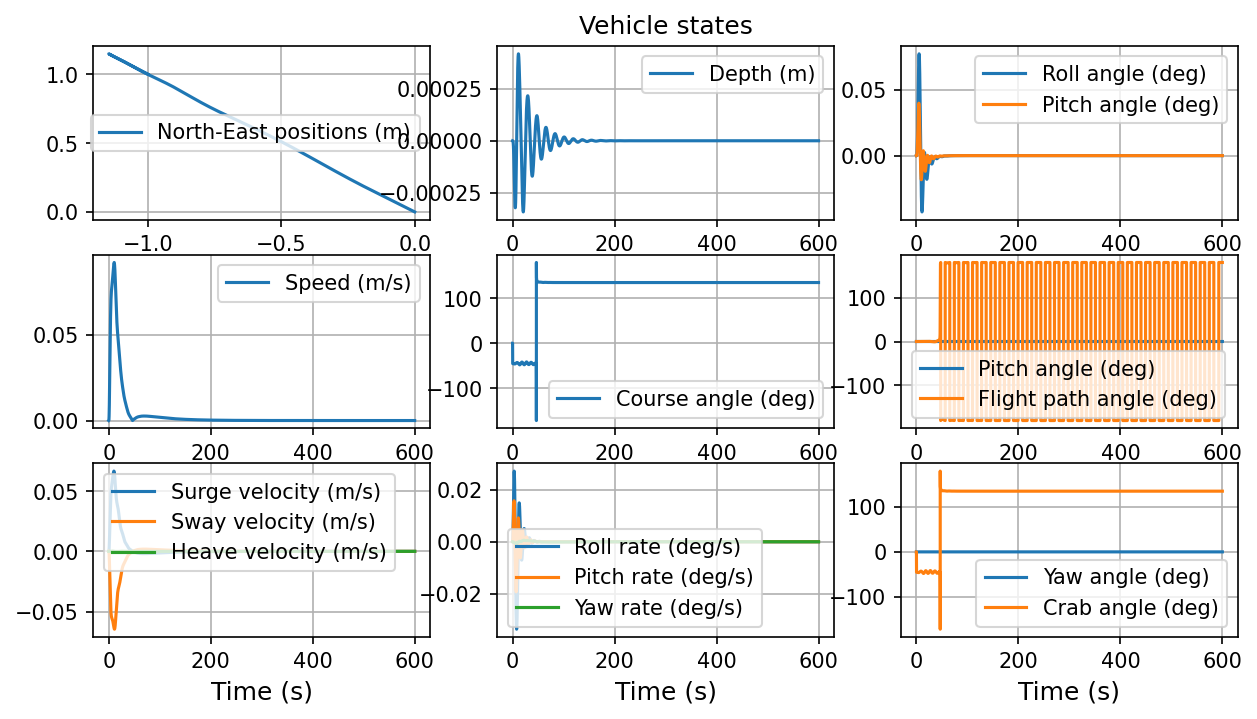

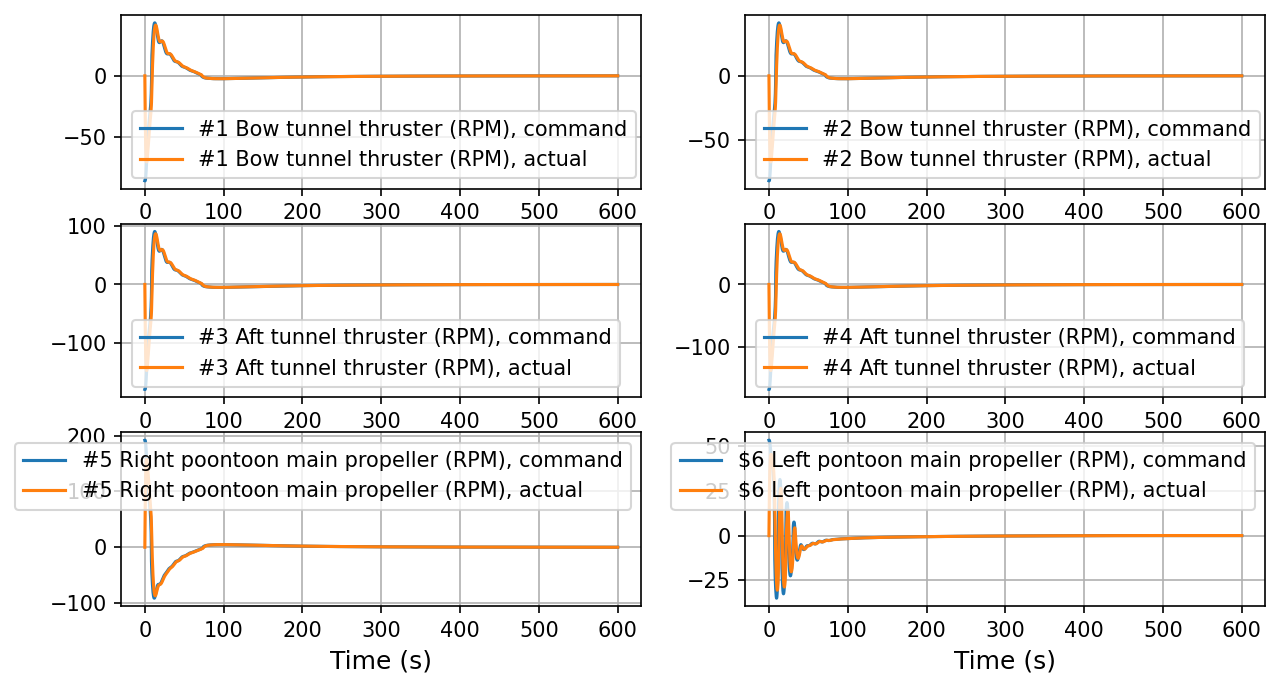

In [103]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [104]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

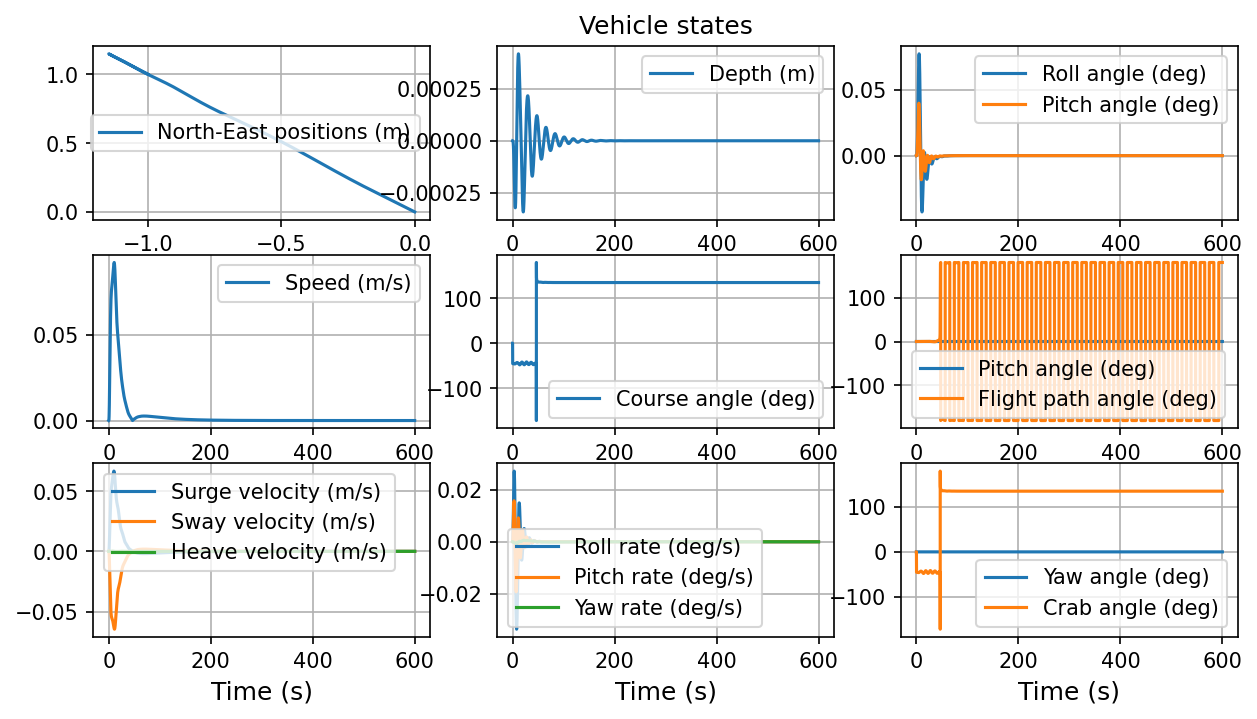

In [105]:
plotVehicleStates(simTime, simData, 3)

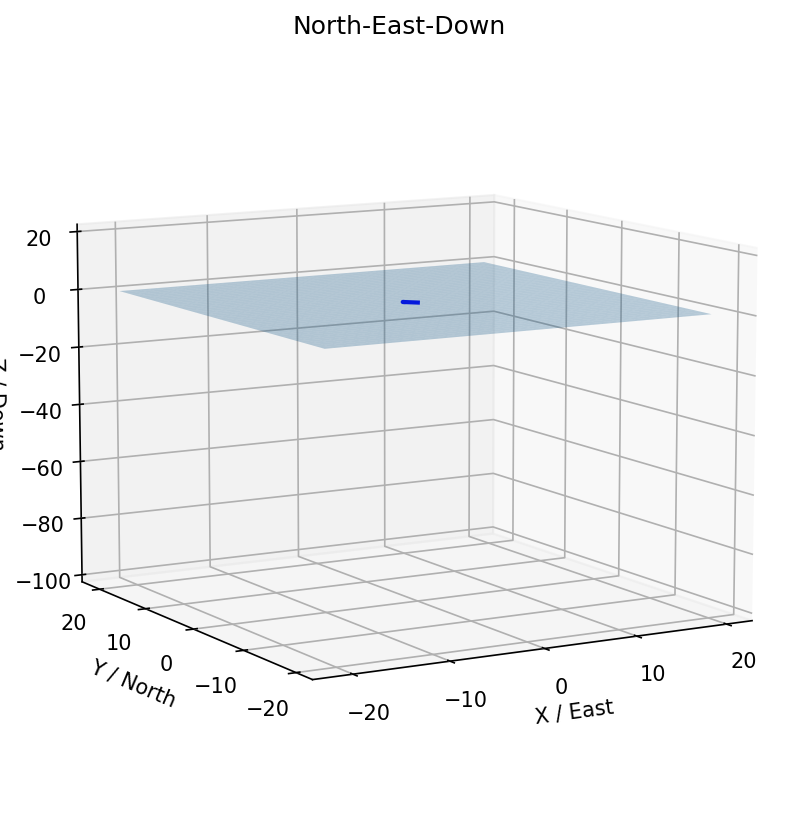

In [106]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [107]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [108]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0
        self.max_bending_strain=0
        self.max_bending_strain1=0

In [109]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [110]:
V_rho=np.zeros(Jrho0.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [111]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [112]:
def dynamic_func(t, Q, coefs, T, calibr):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    del_t = idx-T.my_t
    if del_t<0:
        idx=T.my_t
        
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
#     print(x_ve,y_ve,z_ve)
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    
    vessel_movement[0] = (x_ve - T.x_ve)
    vessel_movement[1] = (y_ve - T.y_ve)
    vessel_movement[2] = (z_ve - T.z_ve)
    vessel_movement[3] = (phi_ve - T.phi_ve)
    vessel_movement[4] = (theta_ve - T.theta_ve)
    vessel_movement[5] = (psi_ve - T.psi_ve)

    vessel_movement/=calibr
    

    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    Z0 = fors.squeeze()
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 
         - Z0
        )

############################################################
#     ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
    ddx,ddy, ddz = (Z/Ws[0]).T    
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0)


    A0 = Jrho(RET,Jrho0)
#     A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################

    T.my_t=idx
    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()   
    
    # artificially limit z acceleration to match actual vessel movement 
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, np.sin((2*3.14/Tp)*(ddz)*t)*z_acceleration_factor, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
   
   
    ax=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET),ne(x, y, z, φ, θ, ψ)))/(mp*9.81*h)
    W = 3.14*(d0**4-dI**4)/(32*d0)
    
    T.max_bending_strain=max(T.max_bending_strain,(ax*12/W)/E)
    
    ben=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET), me(φ, θ, ψ, φ, θ, ψ)))/(mp*9.81*1**2)
    T.max_bending_strain1=max(T.max_bending_strain1,(ben/W)/E)

    return ans

In [113]:
T_ = MyTime()

# initial conditions
q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.00000236*i/N for i in range(N)]))

In [114]:
startTime1 = datetime.now()
us_=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs, T_, vessel_motion_calibration_coefficient,))
print(datetime.now() - startTime1)

Physical time:  6.339401302235669e-06  Iteration wall clock time:  0:00:00.054390
Physical time:  1.0045492360641426  Iteration wall clock time:  0:00:02.267185
Physical time:  2.0036683982300016  Iteration wall clock time:  0:00:01.495623
Physical time:  3.0068841686068097  Iteration wall clock time:  0:00:01.420415
Physical time:  4.025739045056196  Iteration wall clock time:  0:00:01.470697
Physical time:  5.011457295329507  Iteration wall clock time:  0:00:01.948611
Physical time:  6.053773689547266  Iteration wall clock time:  0:00:01.493287
Physical time:  7.003751658502583  Iteration wall clock time:  0:00:01.831973
Physical time:  8.040939033928693  Iteration wall clock time:  0:00:01.592432
Physical time:  9.003526939381112  Iteration wall clock time:  0:00:01.498389
Physical time:  10.00177980972987  Iteration wall clock time:  0:00:01.693260
Physical time:  11.000455315497867  Iteration wall clock time:  0:00:01.617198
Physical time:  12.005668259987877  Iteration wall clock

In [115]:
# max bending strain
T_.max_bending_strain*mp*9.81*h

0.04959779274753557

In [116]:
T_.max_bending_strain1*mp*9.81*1**2

1.2305348931265772

In [117]:
# axial tension
W = 3.14*(d0**4-dI**4)/(32*d0)
T_.max_bending_strain*mp*9.81*h*W*E/12

3358828.636901448

### Results

In [118]:
fin=us_

In [119]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.339e-04 ...  9.993e+01  1.000e+02]
        y: [[ 0.000e+00  3.835e-32 ...  1.103e-06  1.105e-06]
            [ 1.706e+01  1.706e+01 ...  1.766e+01  1.766e+01]
            ...
            [ 0.000e+00 -3.216e-18 ... -2.002e-13 -2.139e-13]
            [ 0.000e+00 -2.249e-18 ...  1.182e-13  1.255e-13]]
      sol: None
 t_events: None
 y_events: None
     nfev: 8486
     njev: 0
      nlu: 0

In [120]:
t=fin.t

In [121]:
fin=fin.y.T

In [122]:
t.shape, fin.shape

((1050,), (1050, 192))

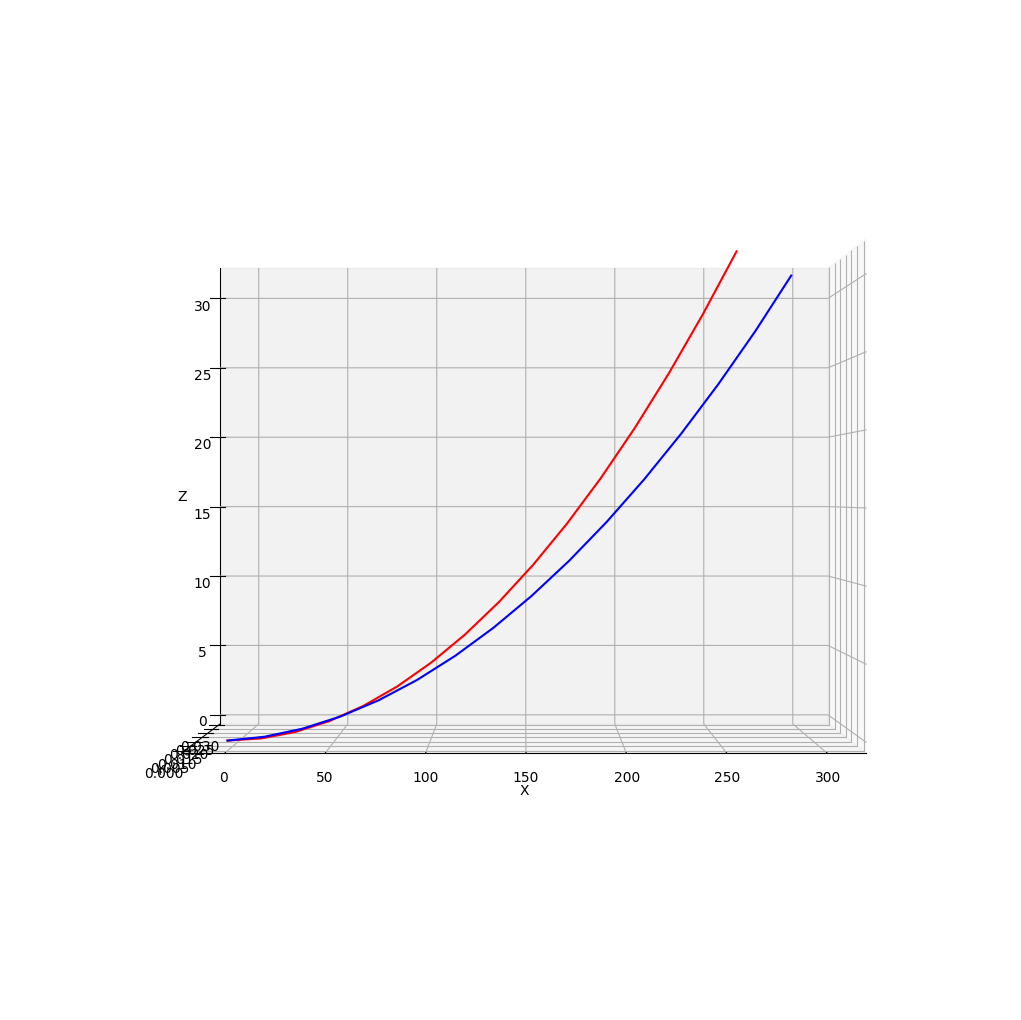

In [123]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [124]:
X,Y,Z

(array([1.10458696e-06, 1.76613364e+01, 3.60476357e+01, 5.48309988e+01,
        7.39348741e+01, 9.33156080e+01, 1.12943773e+02, 1.32797653e+02,
        1.52860829e+02, 1.73120041e+02, 1.93564266e+02, 2.14184237e+02,
        2.34972352e+02, 2.55921584e+02, 2.77026066e+02, 2.98056458e+02]),
 array([1.10457268e-10, 1.82280364e-03, 3.65922412e-03, 5.52601301e-03,
        7.41771151e-03, 9.33047845e-03, 1.12615411e-02, 1.32087981e-02,
        1.51706441e-02, 1.71457904e-02, 1.91331645e-02, 2.11319072e-02,
        2.31413274e-02, 2.51608310e-02, 2.71899181e-02, 2.92062277e-02]),
 array([-1.02129663e-06,  1.39448206e-01,  5.57857883e-01,  1.25542424e+00,
         2.23204647e+00,  3.48824644e+00,  5.02442928e+00,  6.84056442e+00,
         8.93753729e+00,  1.13159674e+01,  1.39762279e+01,  1.69189011e+01,
         2.01454456e+01,  2.36561249e+01,  2.74521369e+01,  3.15342999e+01]))

In [125]:
X0,Y0,Z0

(array([  0.        ,  17.05660616,  34.11321231,  51.16981847,
         68.22642463,  85.28303078, 102.33963694, 119.3962431 ,
        136.45284925, 153.50945541, 170.56606157, 187.62266772,
        204.67927388, 221.73588004, 238.79248619, 255.84909235]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.        ,  0.13945484,  0.55785664,  1.25531728,  2.23202324,
         3.48823569,  5.0242905 ,  6.84059839,  8.93764501, 11.31599107,
        13.97627251, 16.91920062, 20.1455623 , 23.65622021, 27.45211306,
        31.53425578]))

In [126]:
us=fin.T

In [127]:
us.shape

(192, 1050)

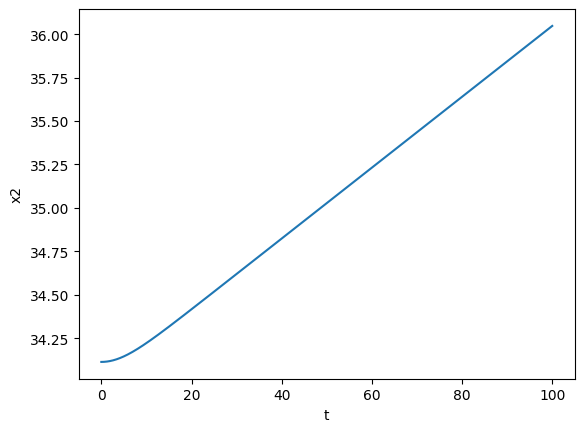

In [128]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

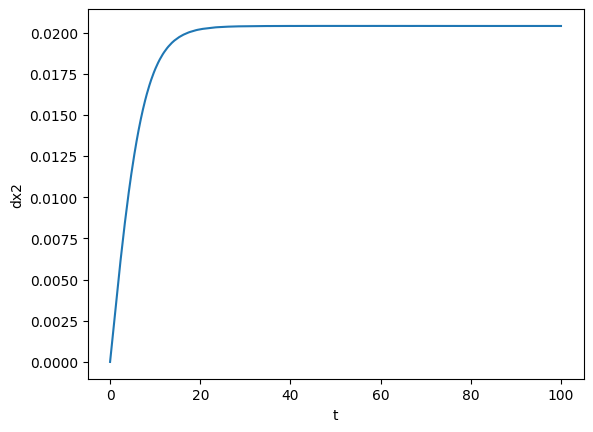

In [129]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

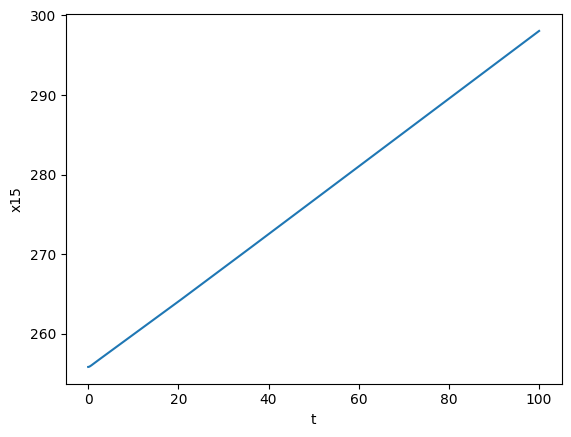

In [130]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

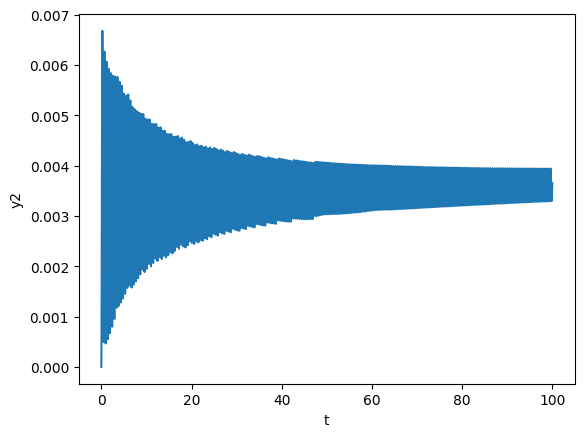

In [131]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

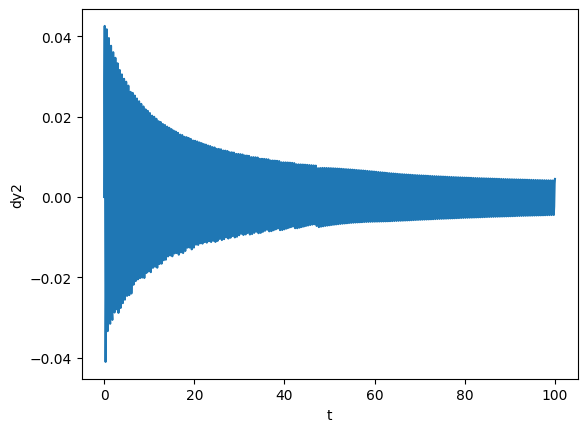

In [132]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

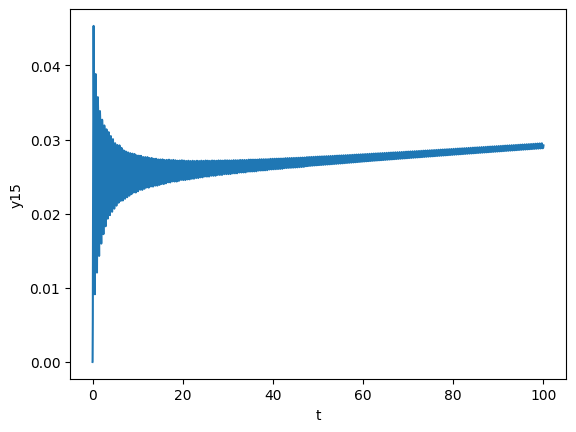

In [133]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

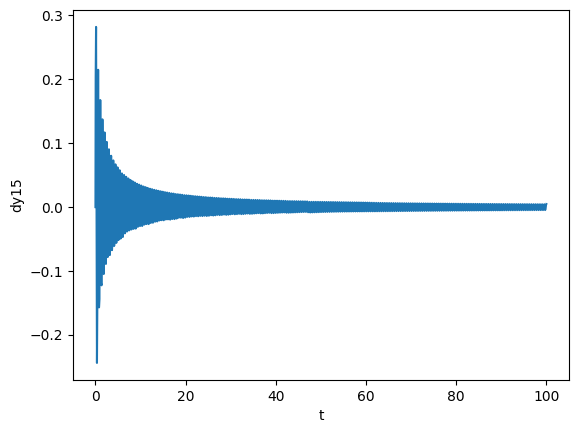

In [134]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

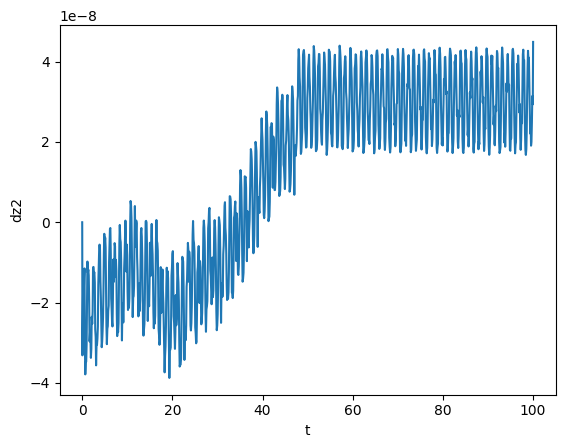

In [135]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

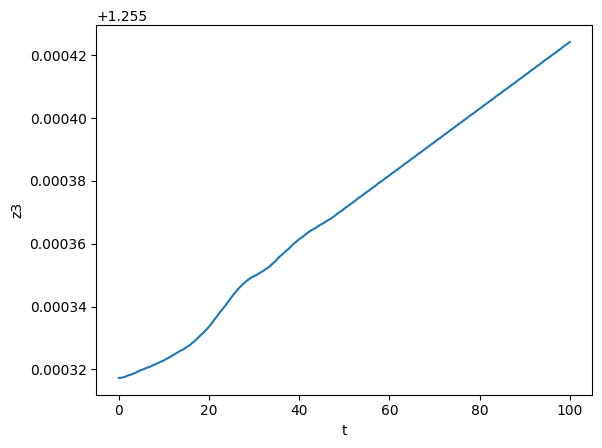

In [136]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

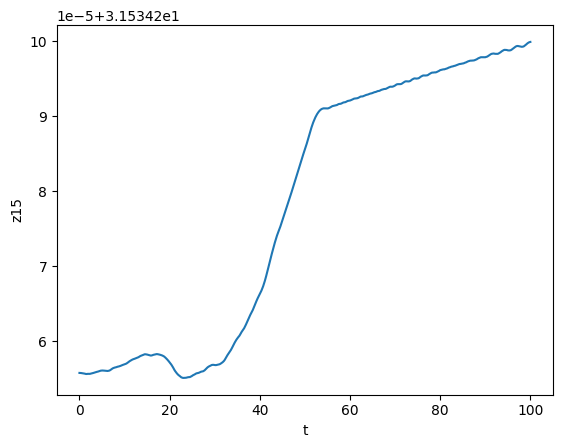

In [137]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

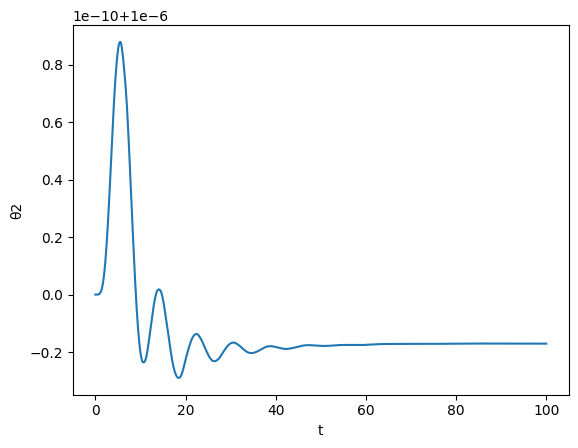

In [138]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

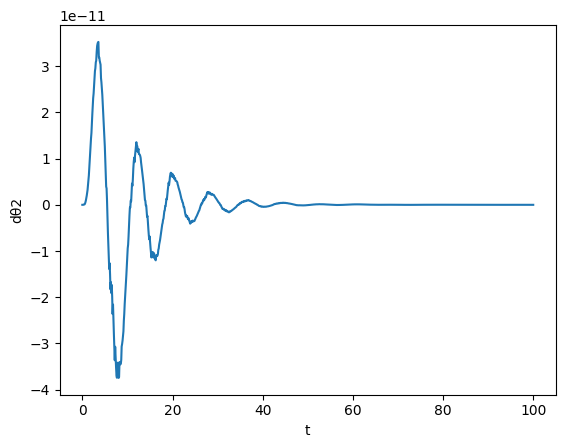

In [139]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

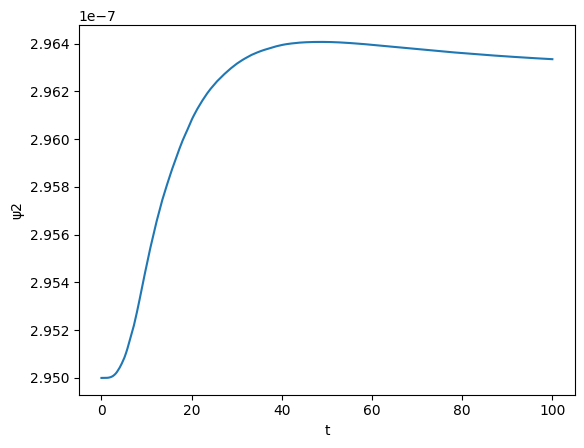

In [140]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

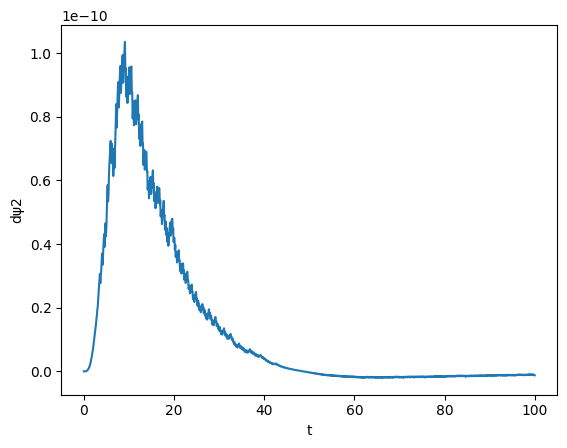

In [141]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

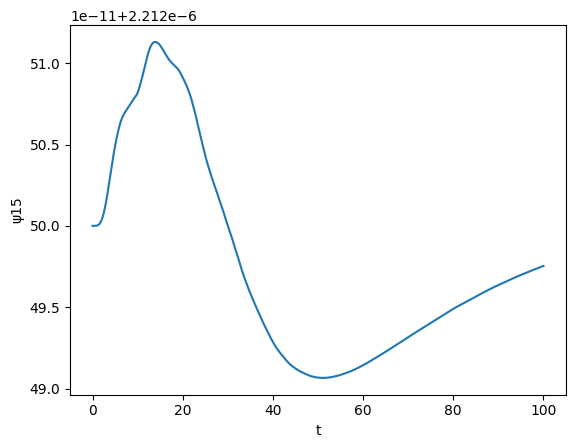

In [142]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()